# 1. Loading Relevant Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import scipy.stats as stats
import os
import pickle
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.stats import ttest_ind
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


# 2. DefiningFunctions

In [2]:
# Normalization using z-score
def zscore(x):
    """
    Applies z-score normalization to a pandas Series.
    
    Args:
        x (pd.Series): The series (column) to normalize.
    
    Returns:
        pd.Series: The normalized series with mean 0 and standard deviation 1.
    """
    return (x - x.mean()) / x.std()



In [3]:
# Merging phenotype and PRS data for a cohort
def merging_pheno_and_prs_per_cohort(df_pheno, df_prs):
    """
    Merges phenotype and PRS data based on the 'IID' column and renames key variables. 
    Filters and retains relevant columns, and removes rows with missing data (NaN).
    
    Args:
        df_pheno (pd.DataFrame): The phenotype data for the cohort.
        df_prs (pd.DataFrame): The PRS data for the cohort.
    
    Returns:
        pd.DataFrame: A dataframe containing merged and cleaned phenotype and PRS data.
    """
    
    # Merge phenotype and PRS data on 'IID' (individual ID)
    df = df_prs.merge(df_pheno, on='IID')

    # Rename 'PRS' column to 'SCORE' and 'ADRD' to 'ADRD_FINAL'
    df = df.rename(columns={'PRS': 'SCORE', 'ADRD': 'ADRD_FINAL'})

    # Select relevant columns for analysis
    df = df[['IID', 'ADRD_FINAL', 'SCORE', 'AGE', 'SEX', 'APOEe4']]

    # Remove rows with missing values (NaN)
    df = df.dropna()

    # Display the shape of the final dataframe (number of rows and columns)
    print(df.shape)

    # Return the cleaned and merged dataframe
    return df

In [4]:
# normalization
def zscore(x):
    return (x - x.mean()) / x.std()

# mergin pheno and prs
def merging_pheno_and_prs_per_cohort(df_pheno,df_prs):

    df = df_prs.merge(df_pheno, on='IID')
    df = df.rename(columns={'PRS':'SCORE'})
    df = df.rename(columns={'ADRD':'ADRD_FINAL'})

    df = df[['IID','ADRD_FINAL','SCORE','AGE','SEX','APOEe4']]
    df = df.dropna()
    df    
    print(df.shape)
    return df


In [5]:
def load_data(cohort, path):
    """
    Loads phenotype and PRS data for a given cohort, preprocesses the data by filtering 
    and standardizing key variables, and merges phenotype and PRS data into a single dataframe.

    Args:
        cohort (str): The name of the cohort (used for identifying files).
        path (str): The path to the directory containing the cohort data files.

    Returns:
        pd.DataFrame: A dataframe with merged and preprocessed phenotype and PRS data.
    """

    # Load phenotype data
    pheno_file_path = f"{path}{cohort}/pheno_data1.txt"
    df_pheno = pd.read_csv(pheno_file_path, sep='\t')
    #print(df_pheno)

    # Load PRS data and filter based on the 'In_Regression' column
    prs_file_path = f"{path}{cohort}/prs_data1.txt"
    df_prs = pd.read_csv(prs_file_path, sep=' ')
    df_prs = df_prs[df_prs['In_Regression'] == 'Yes']  # Keep only relevant rows for regression
    #print(df_prs)

    # Merge phenotype and PRS data into a single dataframe
    df_ready = merging_pheno_and_prs_per_cohort(df_pheno, df_prs)
    #print(df_ready)

    # Standardize AGE and SCORE columns using z-score normalization
    df_ready['AGE'] = zscore(df_ready['AGE'])
    df_ready['SCORE'] = zscore(df_ready['SCORE'])
    print(df_ready)

    # Recode SEX column: 1 -> 0, 2 -> 1
    df_ready['SEX'] = df_ready['SEX'].replace({1: 0, 2: 1})

    # Return the processed dataframe
    return df_ready


In [6]:
def train_and_plot_roc_using_log(df, cohort, base, features):
    """
    Trains a logistic regression model using SMOTE for oversampling, 
    performs hyperparameter tuning, and plots the ROC curve for each feature set.
    
    Args:
        df (pd.DataFrame): The input dataframe containing the data.
        cohort (str): The name of the cohort.
        base (str): The base feature to be used for comparison.
        features (list of list): A list of feature sets to use in the model.
    
    Returns:
        tuple: fpr, tpr, best model, AUC values, mean AUC values, AUC standard errors, and AUC sample list.
    """
    
    # Initialize lists to store AUC values and confidence intervals
    list_auc = []
    list_mean_auc = []
    list_std_err_auc = []
    auc_sign_list = []

    # Set up the plot for the ROC curves
    plt.figure(figsize=(8, 6))

    # Iterate over the different feature sets to train the model and plot ROC curves
    for feature_set, color in zip(features, ['indianred', 'cornflowerblue', 'mediumseagreen', 'dimgrey']):
        # Select the features (X) and target variable (y)
        X_train = df[feature_set]
        y_train = df['ADRD_FINAL']

        # Apply SMOTE to address class imbalance
        smote = SMOTE(random_state=1234)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Split data into training and test sets (75% train, 25% test)
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)
        y_train, y_test = y_train.astype('int'), y_test.astype('int')  # Ensure target is in integer format

        print("Training data shape:", X_train.shape)
        print("Test data shape:", X_test.shape)

        # Set up hyperparameter tuning for logistic regression
        random_seed = 42
        np.random.seed(random_seed)

        # Define the parameter grid for GridSearchCV
        param_grid = {
            'C': [0.1, 1, 10, 100],      # Regularization strength
            'penalty': ['l1', 'l2'],     # Regularization type
            'solver': ['liblinear']      # Solver (works with l1 and l2 penalties)
        }

        # Initialize the Logistic Regression classifier with balanced class weights
        temp_model = LogisticRegression(random_state=random_seed, class_weight='balanced')

        # Use GridSearchCV for hyperparameter tuning with cross-validation (5-fold)
        grid_search = GridSearchCV(temp_model, param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get the best model from GridSearchCV
        model = grid_search.best_estimator_

        # Get predicted probabilities for the test set
        y_prob = model.predict_proba(X_test)[:, 1]

        # Calculate the ROC curve and AUC score
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        list_auc.append(roc_auc)

        # Reset index for y_test and y_prob (if needed)
        y_test = y_test.reset_index(drop=True)
        y_prob = pd.Series(y_prob).reset_index(drop=True)

        # Calculate mean AUC and confidence intervals using bootstrapping
        mean_auc, std_err_auc = bootstrap_auc(y_test, y_prob)
        mean_auc, lower_ci, upper_ci = calculate_auc_ci(y_test, y_prob)
        std_err_auc = [lower_ci, upper_ci]
        list_mean_auc.append(mean_auc)
        list_std_err_auc.append(std_err_auc)

        # Calculate confusion matrix metrics: Sensitivity and Specificity
        y_pred = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Plot the ROC curve
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'Diagnosis ~ {feature_set} :\n AUC = {roc_auc:.2f},\n Sensitivity = {sensitivity:.2f},\n Specificity = {specificity:.2f}')

        # Track sample size and AUC value for further analysis
        n_sample = len(y_prob)
        auc_sign_list.append([n_sample, roc_auc])
        print("AUC: ", roc_auc, "Sample size:", n_sample)

    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Set plot labels and title
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=20)
    plt.ylabel('True Positive Rate (TPR)', fontsize=20)
    plt.title(f'{base} as base, and {cohort} as target', fontsize=15)
    plt.legend(loc="lower right")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(True)

    # Display the plot
    plt.show()

    # Return relevant outputs
    return fpr, tpr, model, list_auc, list_mean_auc, list_std_err_auc, auc_sign_list



In [7]:
# Function to compute meand AUC and STD

def bootstrap_auc(y_true, y_pred_prob, n_bootstraps=1000, random_seed=42):
    rng = np.random.RandomState(random_seed)
    bootstrapped_aucs = []
    
    for i in range(n_bootstraps):
        # Bootstrap by sampling with replacement
        indices = rng.randint(0, len(y_pred_prob), len(y_pred_prob))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for computing AUC
            continue
        
        # Compute the FPR and TPR for the bootstrap sample
        fpr, tpr, _ = roc_curve(y_true[indices], y_pred_prob[indices])
        
        # Compute the AUC using the auc() function
        score = auc(fpr, tpr)
        bootstrapped_aucs.append(score)
    
    # Compute the mean and standard error of AUC
    bootstrapped_aucs = np.array(bootstrapped_aucs)
    mean_auc = np.mean(bootstrapped_aucs)
    std_err_auc = np.std(bootstrapped_aucs)
    
    return mean_auc, std_err_auc

In [8]:
# Function to calculate AUC and its confidence interval
def calculate_auc_ci(y_true, y_probs, n_bootstraps=1000, alpha=0.95):
    bootstrapped_aucs = []
    rng = np.random.RandomState(42)
    for i in range(n_bootstraps):
        # Bootstrap by sampling with replacement
        indices = rng.randint(0, len(y_probs), len(y_probs))
        if len(np.unique(y_true[indices])) < 2:
            continue
        fpr, tpr, _ = roc_curve(y_true[indices], y_probs[indices])
        score = auc(fpr, tpr)
        bootstrapped_aucs.append(score)
    sorted_scores = np.array(bootstrapped_aucs)
    sorted_scores.sort()
    # Calculate the confidence interval
    lower_bound = np.percentile(sorted_scores, ((1.0 - alpha) / 2.0) * 100)
    upper_bound = np.percentile(sorted_scores, (alpha + ((1.0 - alpha) / 2.0)) * 100)
    return np.mean(bootstrapped_aucs), lower_bound, upper_bound

# 3. Callling pipeline

(400, 6)
            IID  ADRD_FINAL     SCORE       AGE  SEX  APOEe4
0    6100022501         0.0  1.125642  1.485760  2.0     0.0
1    2501000501         1.0  2.334655 -0.495666  2.0     0.0
2    6100052901         1.0 -1.200863  1.981116  2.0     0.0
3    5500000201         0.0  1.349845 -0.991023  2.0     0.0
4    6100036101         0.0 -0.097110 -0.743344  1.0     0.0
..          ...         ...       ...       ...  ...     ...
395         867         0.0 -1.419278  0.618886  1.0     0.0
396         262         0.0 -0.066685 -0.619505  2.0     0.0
397         943         0.0 -1.450293 -1.610218  2.0     0.0
398         189         0.0 -0.115162 -0.619505  2.0     0.0
399         938         1.0  0.659558  1.609599  1.0     0.0

[400 rows x 6 columns]
Training data shape: (519, 1)
Test data shape: (173, 1)
Fitting 5 folds for each of 8 candidates, totalling 40 fits
AUC:  0.5853658536585366 Sample size: 173


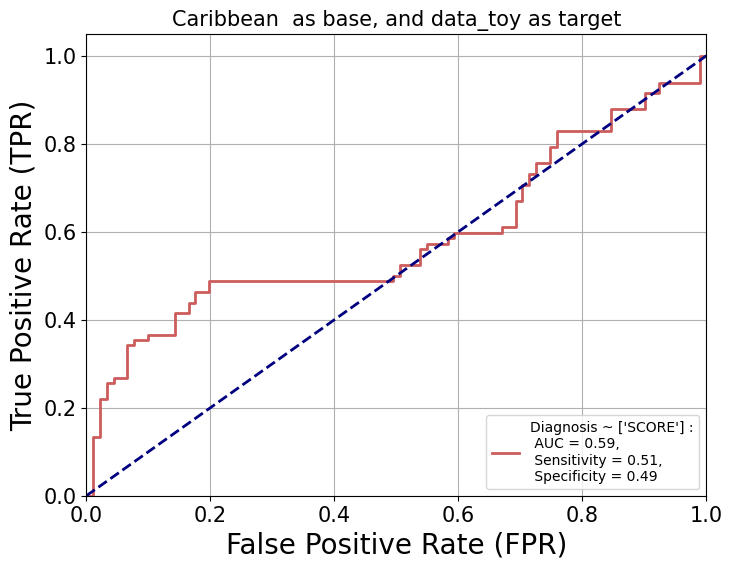

In [9]:
# some global variables
list_cohorts = ['data_toy']
path="../data/"
base="Caribbean "

# iterate through models
for cohort in list_cohorts:
    df_ready = load_data(cohort,path)

    list_auc_all_cohorts_rf = []
    all_cohort_list_mean_auc_rf =[]
    all_cohort_list_std_auc_rf = []
    all_auc_sign_list_rf = []

    fpr, tpr, model,list_auc,list_mean_auc, list_std_err_auc,auc_sign_list = train_and_plot_roc_using_log(df_ready,cohort,base,[['SCORE']])
    list_auc_all_cohorts_rf.append(list_auc); all_cohort_list_mean_auc_rf.append(list_mean_auc);all_cohort_list_std_auc_rf.append(list_std_err_auc);all_auc_sign_list_rf.append(auc_sign_list)  
    # format output

    # mean
    df_mean = pd.DataFrame(all_cohort_list_mean_auc_rf,columns=['mean'])
    # Flattening the list and creating a DataFrame - ci
    df_ci = pd.DataFrame([item[0] for item in all_cohort_list_std_auc_rf], columns=['lower_ci', 'upper_ci'])
    # concat dataframe
    df =  pd.concat([df_mean,df_ci],axis=1)




In [56]:
df_ready['AGE']

0      76.0
1      60.0
2      80.0
3      56.0
4      58.0
       ... 
395    69.0
396    59.0
397    51.0
398    59.0
399    77.0
Name: AGE, Length: 400, dtype: float64